In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

Let A be the concentration of autoinducer (AI)\
Let L be the fraction of luminescent cells\
Let N be the cell density\
Model rate of change of A as a function N \
dA/dt = H1(A, N)*A - k1 * A 

Model the rate of change of fraction of luminescent cells as a function of A,N - Hill Function \
dL/dt = H2(A, N)*L - k2 * L

H1(A, N) is a hill function that models the rate of AI production by the cells\
k1 is the rate of AI degradation or dilution\
H1(A, N) is a hill function that models the rate of transition from non-luminescent to luminescent state\
k2 is the rate of transition from luminescent to non-luminescent state\

H(A) is the Hill function suitable for describing the switching behavior. \
A function of A alone

H(A) = (A^n) / (K^n + A^n)

A Function of both A and N \
H(A, N) = (A^n * N^m) / (K^n + A^n * N^m)


n,m are the Hill coefficient, which determines the steepness of the switching curve
K is the threshold concentration of AI required for luminescence activation


In [132]:
def hill_function(A, N, n, m, K):
    """
    Hill function with params n, k
    """
    return (A**n)*(N**m) / (K**n + A**n * N**m)
    
# ODE system for the model
def AI_dynamics(y, t, k1, k2, n1, m1, K1, n2, m2, K2, N):
    A ,L  = y
    dA_dt = hill_function(A, N, n1,m1,K1)*A*(1-A) - k1*A
    dL_dt = hill_function(A, N, n2,m2,K2)* L * (1 - L) - k2*L
    return [dA_dt, dL_dt]

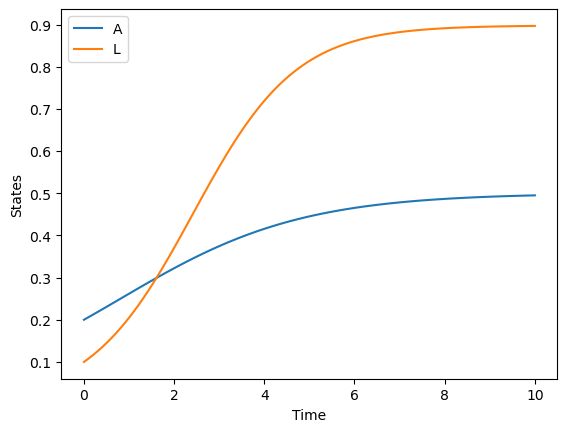

In [142]:
# Parameters
k1 = 0.5
k2 = 0.1
n1 = 3
m1 = 3
K1 = 0.1
n2 = 1
m2 = 2
K2 = 1.0
N = 10

# Initial conditions
A0 = 0.2
L0 = 0.1
y0 = [A0, L0]

# Time points
t = np.linspace(0, 10, 100)

# for different values of N
for i in range(1,N):

# Solve the ODE
sol = odeint(AI_dynamics, y0, t,  args=(k1, k2, n1, m1, K1, n2, m2, K2, N))

# Extract solutions
A = sol[:, 0]
L = sol[:, 1]

plt.plot(t, A, label="A")
plt.plot(t, L, label="L")
plt.xlabel("Time")
plt.ylabel("States")
plt.legend()
plt.show()


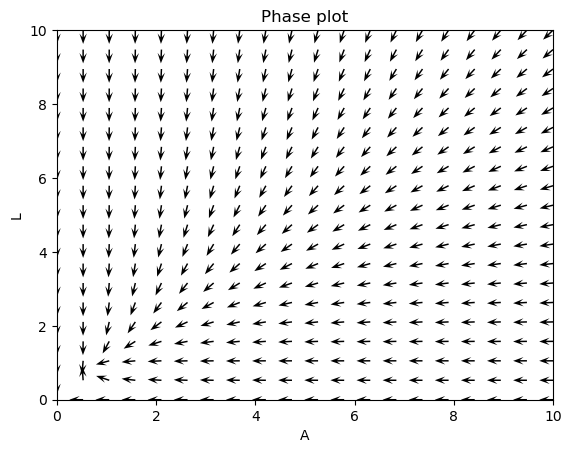

In [136]:
def phase_plot(A_range, L_range, AI_dynamics, params, ax=None, n_grid=20):
    """
    A_range: tuple containing the minimum and maximum values for A.
    L_range: tuple containing the minimum and maximum values for L.
    AI_dynamics: function defining the system of ODEs.
    params: tuple containing the parameters to be passed to the AI_dynamics function.
    ax: matplotlib axes object for plotting (optional).
    n_grid: number of grid points in each dimension (optional, default=20).
    :return: None
    """
    if ax is None:
        ax = plt.gca()

    A_min, A_max = A_range
    L_min, L_max = L_range

    # Create a grid of points
    A_grid, L_grid = np.meshgrid(np.linspace(A_min, A_max, n_grid),
                                 np.linspace(L_min, L_max, n_grid))

    # Compute the derivatives for each point in the grid
    dA_dt, dL_dt = np.zeros(A_grid.shape), np.zeros(L_grid.shape)

    for i in range(n_grid):
        for j in range(n_grid):
            y = [A_grid[i, j], L_grid[i, j]]
            dy_dt = AI_dynamics(y, 0, *params)
            dA_dt[i, j], dL_dt[i, j] = dy_dt

    # Normalize the vectors to have the same length
    M = np.sqrt(dA_dt**2 + dL_dt**2)
    M[M == 0] = 1
    dA_dt /= M
    dL_dt /= M

    # Create the quiver plot
    ax.quiver(A_grid, L_grid, dA_dt, dL_dt, headwidth=5, headlength=7)
    ax.set_xlim(A_min, A_max)
    ax.set_ylim(L_min, L_max)
    ax.set_xlabel('A')
    ax.set_ylabel('L')
    ax.set_title('Phase plot')

    return ax


# Parameters
params = (k1, k2, n1, m1, K1, n2, m2, K2, N)

# Define ranges for A and L
A_range = (0, 10)
L_range = (0, 10)

# Create the phase plot
plt.figure()
phase_plot(A_range, L_range, AI_dynamics, params)
plt.show()

# Model James et al

In [149]:
# 20% serum solution
K = 3E9
r = 0.6
k_u = 74000
k_d = 500
alpha = 1E-11
beta = 600
lamda = 1.5
gamma = 1

# Non-dimensionalization
eps = k_d / k_u
alpha_hat = alpha* k_u* K /r**2
beta_hat = beta/r 
lamda_hat = lamda/r 
mu_hat = alpha* K/r


In [199]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE system
def ODE_system(y, t, gamma, alpha, beta, lambda_, mu, epsilon):
    NT, Nu, A = y
    F_NT = 1 - NT/K
    dNT_dt = NT * F_NT
    dNu_dt = (gamma - 1) * Nu * F_NT + alpha * A * (NT - Nu) - beta * Nu
    dA_dt = Nu + epsilon * (NT - Nu) - mu * A * (NT - Nu) - lambda_ * A
    
    return [dNT_dt, dNu_dt, dA_dt]

# Set parameters and initial conditions
gamma = 0.3
alpha = 0.1
beta = beta_hat
lambda_ = lamda_hat
mu = mu_hat
epsilon = 0.1
NT0, Nu0, A0 = 0.1, 0.05, 0.01
y0 = [NT0, Nu0, A0]

# Set time points for integration
t = np.linspace(0, 20, 1000)
t = t/r

# Solve the ODE for different alpha values and plot the results
alpha_values = [1, 2, 4,6,8,10]
solutions = []
for alpha in alpha_values:
    sol = odeint(ODE_system, y0, t, args=(gamma, alpha, beta, lambda_, mu, epsilon))
    # Extract NT, Nu, and A values
    NT, Nu, A = sol[:, 0], sol[:, 1], sol[:, 2]
    solutions.append([NT,Nu,A])

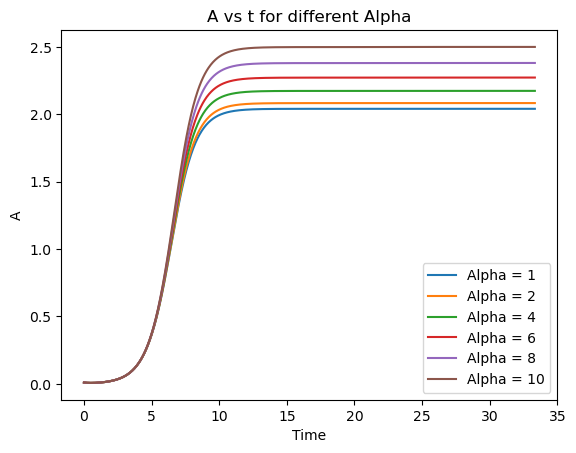

In [200]:
# plot A vs t
plt.figure()
for i,alpha in enumerate(alpha_values):
    A = solutions[i][2]
    plt.plot(t, A, label=f'Alpha = {alpha}')
plt.xlabel('Time')
plt.ylabel('A')
plt.title("A vs t for different Alpha")
plt.legend()
plt.show()

In [201]:
# Set parameters and initial conditions
gamma = 1
alpha = 0.1
beta = 1
lambda_ = 1
mu = 1
epsilon = 0.1
NT0, Nu0, A0 = 0.1, 0, 0
y0 = [NT0, Nu0, A0]

# Set time points for integration
t = np.linspace(0, 20, 1000)
t = t/r

# Solve the ODE for different alpha values and plot the results
alpha_values = [0.1, 0.5, 1, 2,4,6]
solutions = []
for alpha in alpha_values:
    sol = odeint(ODE_system, y0, t, args=(gamma, alpha, beta, lambda_, mu, epsilon))
    # Extract NT, Nu, and A values
    NT, Nu, A = sol[:, 0], sol[:, 1], sol[:, 2]
    solutions.append([NT,Nu,A])

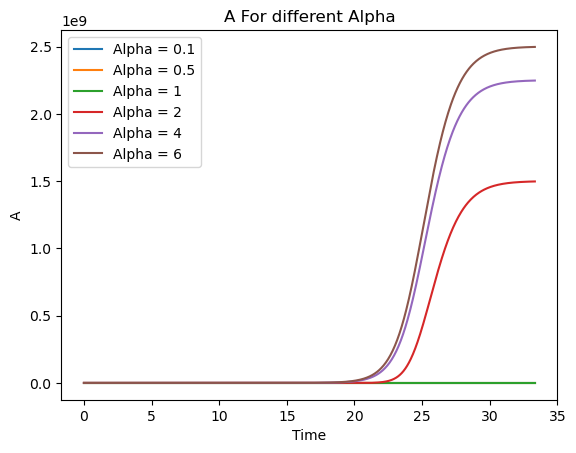

In [202]:
# plot fraction A vs t - Figure 5
plt.figure()
for i,alpha in enumerate(alpha_values):
    A = solutions[i][2]
    plt.plot(t, A, label=f'Alpha = {alpha}')
plt.xlabel('Time')
plt.ylabel('A')
plt.title('A For different Alpha')
plt.legend()
plt.show()

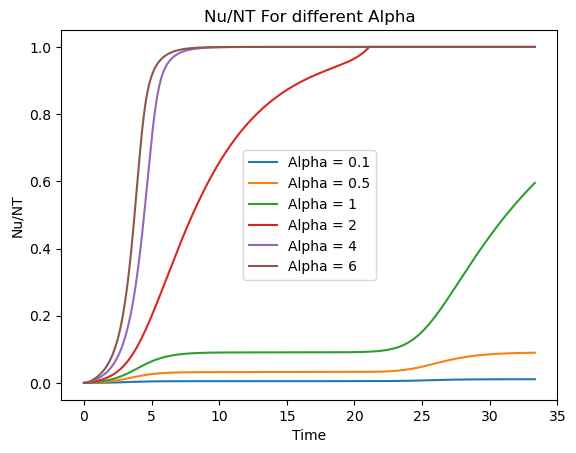

In [203]:
# plot fraction N_U/NT vs t - Figure 4
plt.figure()
for i,alpha in enumerate(alpha_values):
    NT = solutions[i][0]
    Nu = solutions[i][1]
    plt.plot(t, Nu/NT, label=f'Alpha = {alpha}')
plt.xlabel('Time')
plt.ylabel('Nu/NT')
plt.title('Nu/NT For different Alpha')
plt.legend()
plt.show()

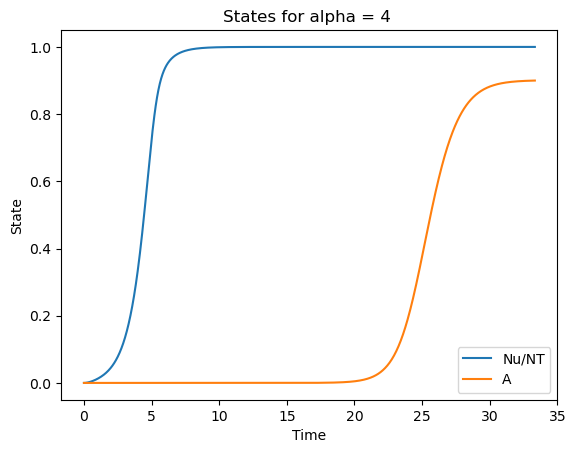

In [206]:
# plot together to see delays Alpha =4
# plot fraction N_U/NT vs t - Figure 4
plt.figure()
alpha = alpha_values[-2]
i = len(alpha_values) - 2
NT = solutions[i][0]
Nu = solutions[i][1]
A = solutions[i][2]/np.max(A)
plt.plot(t, Nu/NT, label= "Nu/NT")
plt.plot(t, A, label= "A")
plt.xlabel('Time')
plt.ylabel('State')
plt.title(f'States for alpha = {alpha} ')
plt.legend()
plt.show()
